In [1]:
%pylab inline

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches


from collections import defaultdict, Counter, OrderedDict

import cytograph as cg
import loompy
import palettable

sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
from scbeta_scrnaseq import utils
from scbeta_scrnaseq import vis
import scbeta_scrnaseq.cytograph_inmem_utils as cgm
import scbeta_scrnaseq.cytograph_analyses as cga

from scbeta_scrnaseq.figure_vis import core_colors
import scbeta_scrnaseq.figure_vis as fv


fv.setup_matplotlib_params()
mm_per_inch = 25.4

Populating the interactive namespace from numpy and matplotlib


In [2]:
samples = ["pscs"]


tds = OrderedDict()
for tp in samples:
    loom_fn = f'../04_Misc/data/complete_processing/{tp}.processed.loom'
    tds[tp] = loompy.connect(loom_fn)
#     tds[tp].vals = sp.sparse.csr_matrix(tds[tp].layers[""][:, :])

In [3]:
import glob

pb_tpm = {}
for pbf in glob.glob('../*/data/complete_processing/*.pseudobulk_tpm.df.npz'):
    key = os.path.basename(pbf)[:-(len('.pseudobulk_tpm.df.npz'))]
    pb_tpm[key] = utils.load_df(pbf)
    
pb_expr = {}
for pbf in glob.glob('../*/data/complete_processing/*.expr_frac.df.npz'):
    key = os.path.basename(pbf)[:-(len('.expr_frac.df.npz'))]
    pb_expr[key] = utils.load_df(pbf)

In [12]:
cell_conditions = {
    'hues8_v4': {
        'color': fv.to_array_col(palettable.wesanderson.Royal1_4.colors[2]),
        'short_label': 'HUES8 (v4)'},
    'hues8_x3': {
        'color': fv.to_array_col(palettable.wesanderson.Royal1_4.colors[3]),
        'short_label' : 'HUES8 (x3)'},
    'ips101631_v4': {
        'color': fv.to_array_col(palettable.wesanderson.Royal1_4.colors[0]),
        'short_label': 'iPS 1016/31 (v4)',
    },
}

label_order = ['pdx1', 'nkx61', 'neurog3',
               'scbeta', 'ph', 'ec', 
               'foxj1', 'sst_hhex', 'exo', 'fev_high_isl_neg', 'repl']
ratio_order = ['pdx1', 'nkx61', 'neurog3',
               'scbeta', 'ec', 'ph', 'pre_ph', 'foxj1', 
               'sst_hhex', 'fev_high_isl_neg', 'exo',  'repl']

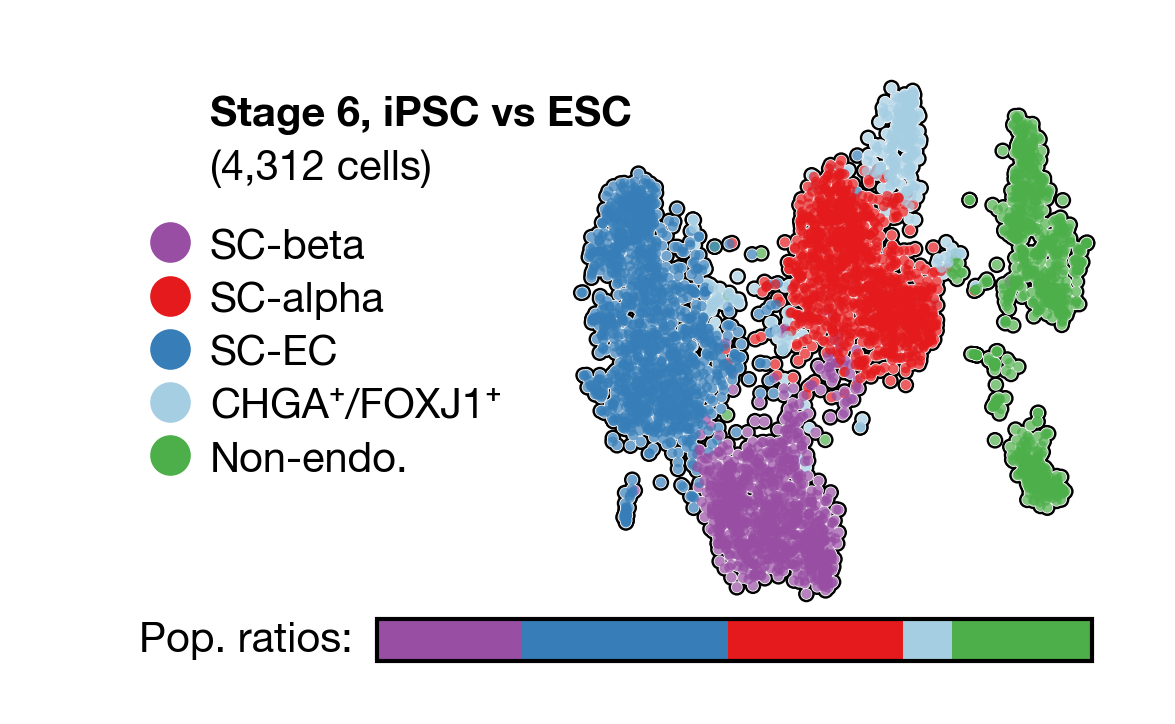

In [13]:

panel_sizing = ((89/2)/mm_per_inch, #Width
                (25.4)/mm_per_inch, #Height
                ) 

cell_pop_bar_h = 0.07

heights = ((1 - cell_pop_bar_h)*panel_sizing[1],
                 cell_pop_bar_h * panel_sizing[1])
widths = (panel_sizing[0] - heights[0],
            heights[0])


fig = plt.figure(figsize=panel_sizing, dpi=600)
gs = gridspec.GridSpec(2, 2, fig, 0,0,1,1,
                       hspace=0, wspace=0,
                       width_ratios=widths,
                       height_ratios=heights)

    
si = 0
_ds = tds['pscs']
tsne_proj = _ds.ca['TSNE']
cell_clusters = _ds.ca['Labels']
label_params = fv.dataset_label_params('')

###### Draw the labels
# 
#

ax = fig.add_subplot(gs[0, 2*si + 0], xticks=[], yticks=[], xlim=[0,1], ylim=[0,1],
          xscale='linear', yscale='linear',
          frameon=False)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xticks([])
ax.set_yticks([])

li = 1
yl_pos = lambda lii: 1 - lii/10.5
xl_pos_dot = 0.22
xl_pos_header = 0.30
xl_pos_text = 0.30

ax.text(xl_pos_header, yl_pos(li), 'Stage 6, iPSC vs ESC', verticalalignment='center', fontsize=5,
        fontdict=dict(weight='bold'),
        clip_on=False)
li += 1

ax.text(xl_pos_header, yl_pos(li),'(%s cells)'%format(len(tsne_proj),',d'), verticalalignment='center', fontsize=5,
        clip_on=False)
li += 1.5

_present_labels = set(cell_clusters)
for lb in [lb for lb in label_order if lb in _present_labels]:
    lb_text = label_params[lb]['short_label']
    ax.scatter(xl_pos_dot, yl_pos(li)+0.01, s=fv.tsne_legend_ms, clip_on=False, c=label_params[lb]['color'].reshape(1,-1))
    for leg_label_line in lb_text.splitlines():            
        ax.text(xl_pos_text, yl_pos(li), leg_label_line, verticalalignment='center', fontsize=5,clip_on=False)
        li += 1

###### Scatter plot
# 
#

_proj, _c = fv.prepare_for_scatter(tsne_proj, cell_clusters, label_params) 

ax = fig.add_subplot(gs[0, 2*si + 1], xticks=[], yticks=[],
              xscale='linear', yscale='linear',
              frameon=False,  zorder=-1)
ax.patch.set_visible(False)

s_black_, s_white, s_type = 4, 2, 1.5
ax.scatter(_proj[:, 0], _proj[:, 1], c='k', edgecolor='none', s=s_black_, 
               rasterized=True)
ax.scatter(_proj[:, 0], _proj[:, 1], c='w', edgecolor='none', s=s_white, 
               rasterized=True)
ax.scatter(_proj[:, 0], _proj[:, 1], c=_c, edgecolor='none', s=s_type, alpha=0.7,
               rasterized=True)

# Place the tSNE further to the top, right
old_xlim = np.array(ax.get_xlim())
old_ylim = np.array(ax.get_ylim())
shift_amt = 0.2
x_span = old_xlim[1]-old_xlim[0]
y_span = old_ylim[1]-old_ylim[0]
xlim = np.array([old_xlim[0] - shift_amt*(x_span), old_xlim[1]])
ylim = np.array([old_ylim[0] - shift_amt*(y_span)*0.5, old_ylim[1] + shift_amt*(y_span)*0.5])
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

###### Population Ratio Indicator
# 
#

ax = fig.add_subplot(gs[1, (2*si):(2*si + 2)], 
              xticks=[], yticks=[],       
              xlim=[0,1], ylim=[0,1],
              xscale='linear', yscale='linear',
              frameon=False)

n_by_cluster = pd.Series(Counter(cell_clusters))
n_by_cluster = n_by_cluster/n_by_cluster.sum()

cumul_frac = 0
for lb in ratio_order:
    if lb in n_by_cluster:
        cl_frac = n_by_cluster[lb]
        ax.add_patch(
            patches.Rectangle(
                (0.30 + 0.68*cumul_frac, 0.02), (0.68*cl_frac), 1.0,
                facecolor=label_params[lb]['color'], edgecolor='none',
                clip_on=False,
            ))
        cumul_frac += cl_frac

ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax.text(0.175, 0.5, 'Pop. ratios:', verticalalignment='center', horizontalalignment='center', fontsize=5,
        clip_on=False)
ax.add_patch(
        patches.Rectangle(
            (0.30, 0.02), 0.68, 1.0,
            facecolor='none', edgecolor='k', linewidth=0.5, clip_on=False,
        ))
    
fig.savefig('../../figures/components/extended_figure1/iPSC_ESC_tSNE.pdf', dpi=600, transparent=True)


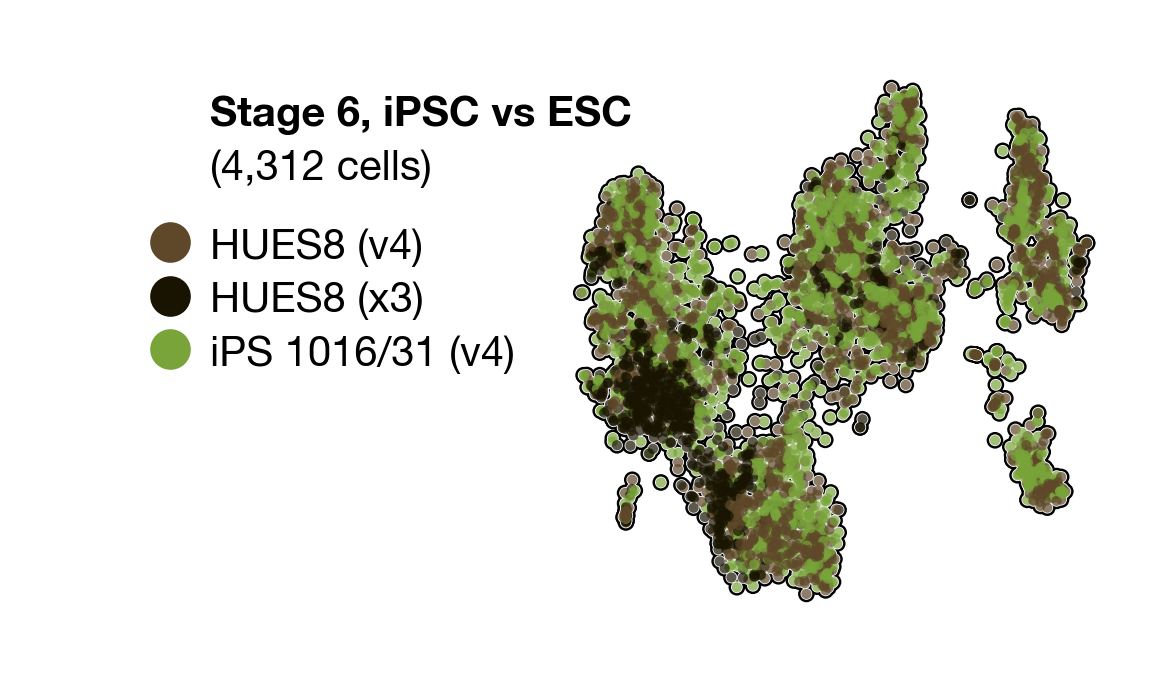

In [7]:

panel_sizing = ((89/2)/mm_per_inch, #Width
                (25.4)/mm_per_inch, #Height
                ) 

cell_pop_bar_h = 0.07

heights = ((1 - cell_pop_bar_h)*panel_sizing[1],
                 cell_pop_bar_h * panel_sizing[1])
widths = (panel_sizing[0] - heights[0],
            heights[0])


fig = plt.figure(figsize=panel_sizing, dpi=600)
gs = gridspec.GridSpec(2, 2, fig, 0,0,1,1,
                       hspace=0, wspace=0,
                       width_ratios=widths,
                       height_ratios=heights)

    
si = 0
_ds = tds['pscs']
tsne_proj = _ds.ca['TSNE']
cell_clusters = _ds.ca.CellCondition
label_params = cell_conditions

###### Draw the labels
# 
#

ax = fig.add_subplot(gs[0, 2*si + 0], xticks=[], yticks=[], xlim=[0,1], ylim=[0,1],
          xscale='linear', yscale='linear',
          frameon=False)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xticks([])
ax.set_yticks([])

li = 1
yl_pos = lambda lii: 1 - lii/10.5
xl_pos_dot = 0.22
xl_pos_header = 0.30
xl_pos_text = 0.30

ax.text(xl_pos_header, yl_pos(li), 'Stage 6, iPSC vs ESC', verticalalignment='center', fontsize=5,
        fontdict=dict(weight='bold'),
        clip_on=False)
li += 1

ax.text(xl_pos_header, yl_pos(li), '(%s cells)'%format(len(tsne_proj),',d'), verticalalignment='center', fontsize=5,
        clip_on=False)
li += 1.5

_present_labels = set(cell_clusters)
# for lb in [lb for lb in label_order if lb in _present_labels]:
for lb in ['hues8_v4', 'hues8_x3', 'ips101631_v4']:
    lb_text = label_params[lb]['short_label']
    ax.scatter(xl_pos_dot, yl_pos(li)+0.01, s=fv.tsne_legend_ms, clip_on=False, c=label_params[lb]['color'].reshape(1,-1))
    for leg_label_line in lb_text.splitlines():            
        ax.text(xl_pos_text, yl_pos(li), leg_label_line, verticalalignment='center', fontsize=5,clip_on=False)
        li += 1

###### Scatter plot
# 
#

_proj, _c = fv.prepare_for_scatter(tsne_proj, cell_clusters, label_params) 

ax = fig.add_subplot(gs[0, 2*si + 1], xticks=[], yticks=[],
              xscale='linear', yscale='linear',
              frameon=False,  zorder=-1)
ax.patch.set_visible(False)

s_black_, s_white, s_type = 4, 2, 1.5
ax.scatter(_proj[:, 0], _proj[:, 1], c='k', edgecolor='none', s=s_black_, 
               rasterized=True)
ax.scatter(_proj[:, 0], _proj[:, 1], c='w', edgecolor='none', s=s_white, 
               rasterized=True)
ax.scatter(_proj[:, 0], _proj[:, 1], c=_c, edgecolor='none', s=s_type, alpha=0.7,
               rasterized=True)

# Place the tSNE further to the top, right
old_xlim = np.array(ax.get_xlim())
old_ylim = np.array(ax.get_ylim())
shift_amt = 0.2
x_span = old_xlim[1]-old_xlim[0]
y_span = old_ylim[1]-old_ylim[0]
xlim = np.array([old_xlim[0] - shift_amt*(x_span), old_xlim[1]])
ylim = np.array([old_ylim[0] - shift_amt*(y_span)*0.5, old_ylim[1] + shift_amt*(y_span)*0.5])
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)


fig.savefig('../../figures/components/extended_figure1/iPSC_ESC_tSNE_protocols.pdf', dpi=600, transparent=True)


In [6]:
_tds = tds['pscs']
hv_genes = _tds.ra.Gene[np.where(_tds.ra['HighVarGene'])[0]]

In [7]:
pb_z = pb_tpm['pscs.line_labels'][hv_genes].copy()
pb_z = (pb_z - pb_z.mean())/pb_z.std(ddof=0)

In [8]:
lines_corr = pb_z.T.corr()

In [9]:
importlib.reload(fv)

<module 'scbeta_scrnaseq.figure_vis' from '/Users/averes/Projects/Melton/Papers/Mapping_SCbeta/2019_02_04_final_version/code/scbeta_scrnaseq/figure_vis.py'>

In [10]:
cl_lo = ['scbeta', 'ec', 'ph', 'exo', 'foxj1' ]
display_corr = lines_corr.loc[[f'hues8__{cl}' for cl in cl_lo], :].loc[:, [f'ips101631__{cl}' for cl in cl_lo]]

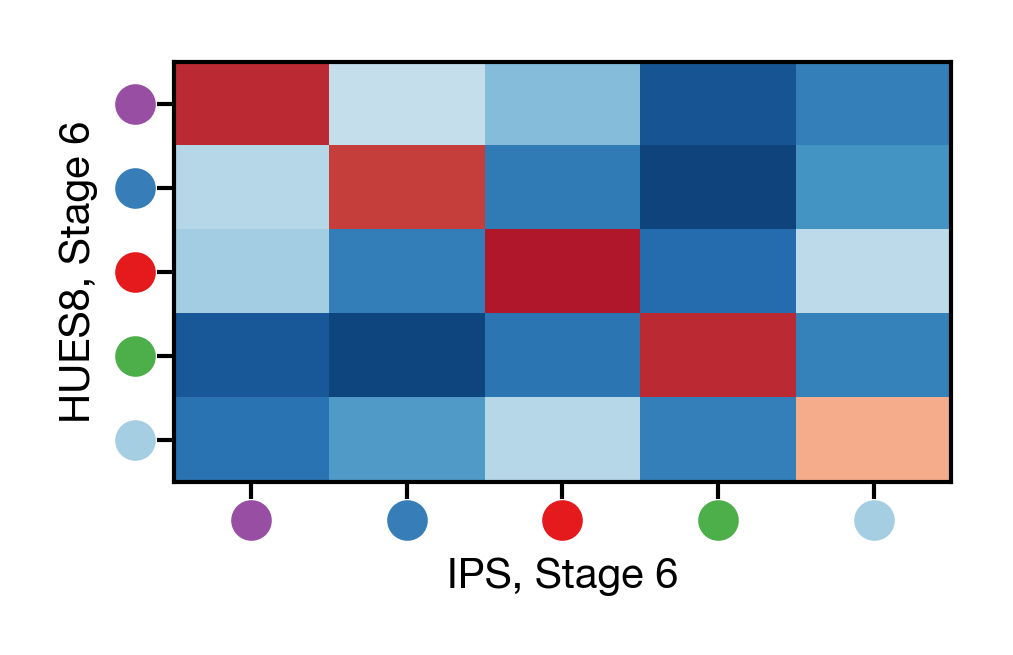

In [14]:

fig = plt.figure(figsize=panel_sizing, dpi=600)
ax = fig.add_axes([0.23, 0.25, 0.74, 0.70],
                  xscale='linear', yscale='linear',
         frameon=True)

ax.set_xlabel('IPS, Stage 6', labelpad=6)
ax.set_ylabel('HUES8, Stage 6', labelpad=6)
imm = ax.imshow(display_corr, cmap='RdBu_r', aspect='auto',
          vmin=-0.5, vmax=1)

labels_params = fv.dataset_label_params('')

for ci,cl in enumerate(cl_lo):
    
    ax.scatter([ci], [len(cl_lo) - 0.04], s=fv.heatmap_legend_ms, c=labels_params[cl]['color_vec'], clip_on=False, zorder=10)
    ax.scatter([-0.75], [ci], s=fv.heatmap_legend_ms, c=labels_params[cl]['color_vec'], clip_on=False, zorder=10)

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlim([-0.5, 4.5])
ax.set_ylim([4.5, -0.5])

fig.savefig('../../figures//components/extended_figure1/ISPC_ESC_corr.pdf', transparent=True)


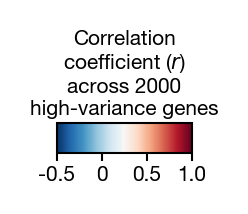

In [34]:

fig = plt.figure(figsize=(0.75,0.75), dpi=300)


cax_position = [0.2, 0.20, 0.60, 0.133]

cax2 = fig.add_axes(cax_position,
                xscale='linear', yscale='linear',
                xlabel='', ylabel='', frameon=True, )

# colorbar(cax=imax)

with plt.rc_context({'axes.linewidth': 0.5}):
    cb = fig.colorbar(imm, cax=cax2, orientation='horizontal', ticks=[-0.5, 0, 0.5, 1.0])
    cb.ax.xaxis.set_label_position('top')
    cb.set_ticklabels(['-0.5', '0', '0.5', '1.0'])
    cb.ax.text(0.25, 1.2, 'Correlation\n'r'coefficient ($\it{r}$)''\nacross 2000\nhigh-variance genes',
               verticalalignment='bottom', horizontalalignment='center',
               fontsize=5, clip_on=False,
              )
    
fig.savefig('../../figures/components/extended_figure1/ISPC_ESC_corr_legend.pdf', transparent=True)